### Importation de l'environnement de travail

#### Objectifs :
 - Analyser un bâtiment cubique avec 5 murs identiques et un mur transparent (fenêtre en verre), une infiltration d'air et un système CVC contrôlant la température de l'air intérieur.
 - Modéliser le transfert de chaleur dans le bâtiment par un circuit thermique.
 - Obtenir le modèle mathématique sous la forme d'un système d'équations algébriques différentielles (DAE) à partir du circuit thermique.
 - Transférez le système d'EAD dans une représentation de l'espace d'état.
 - Trouver la solution en régime permanent.
 - Simuler en utilisant les méthodes d'Euler pour l'intégration numérique...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

### Dimensions du problème et description du batiment étudié

<div>
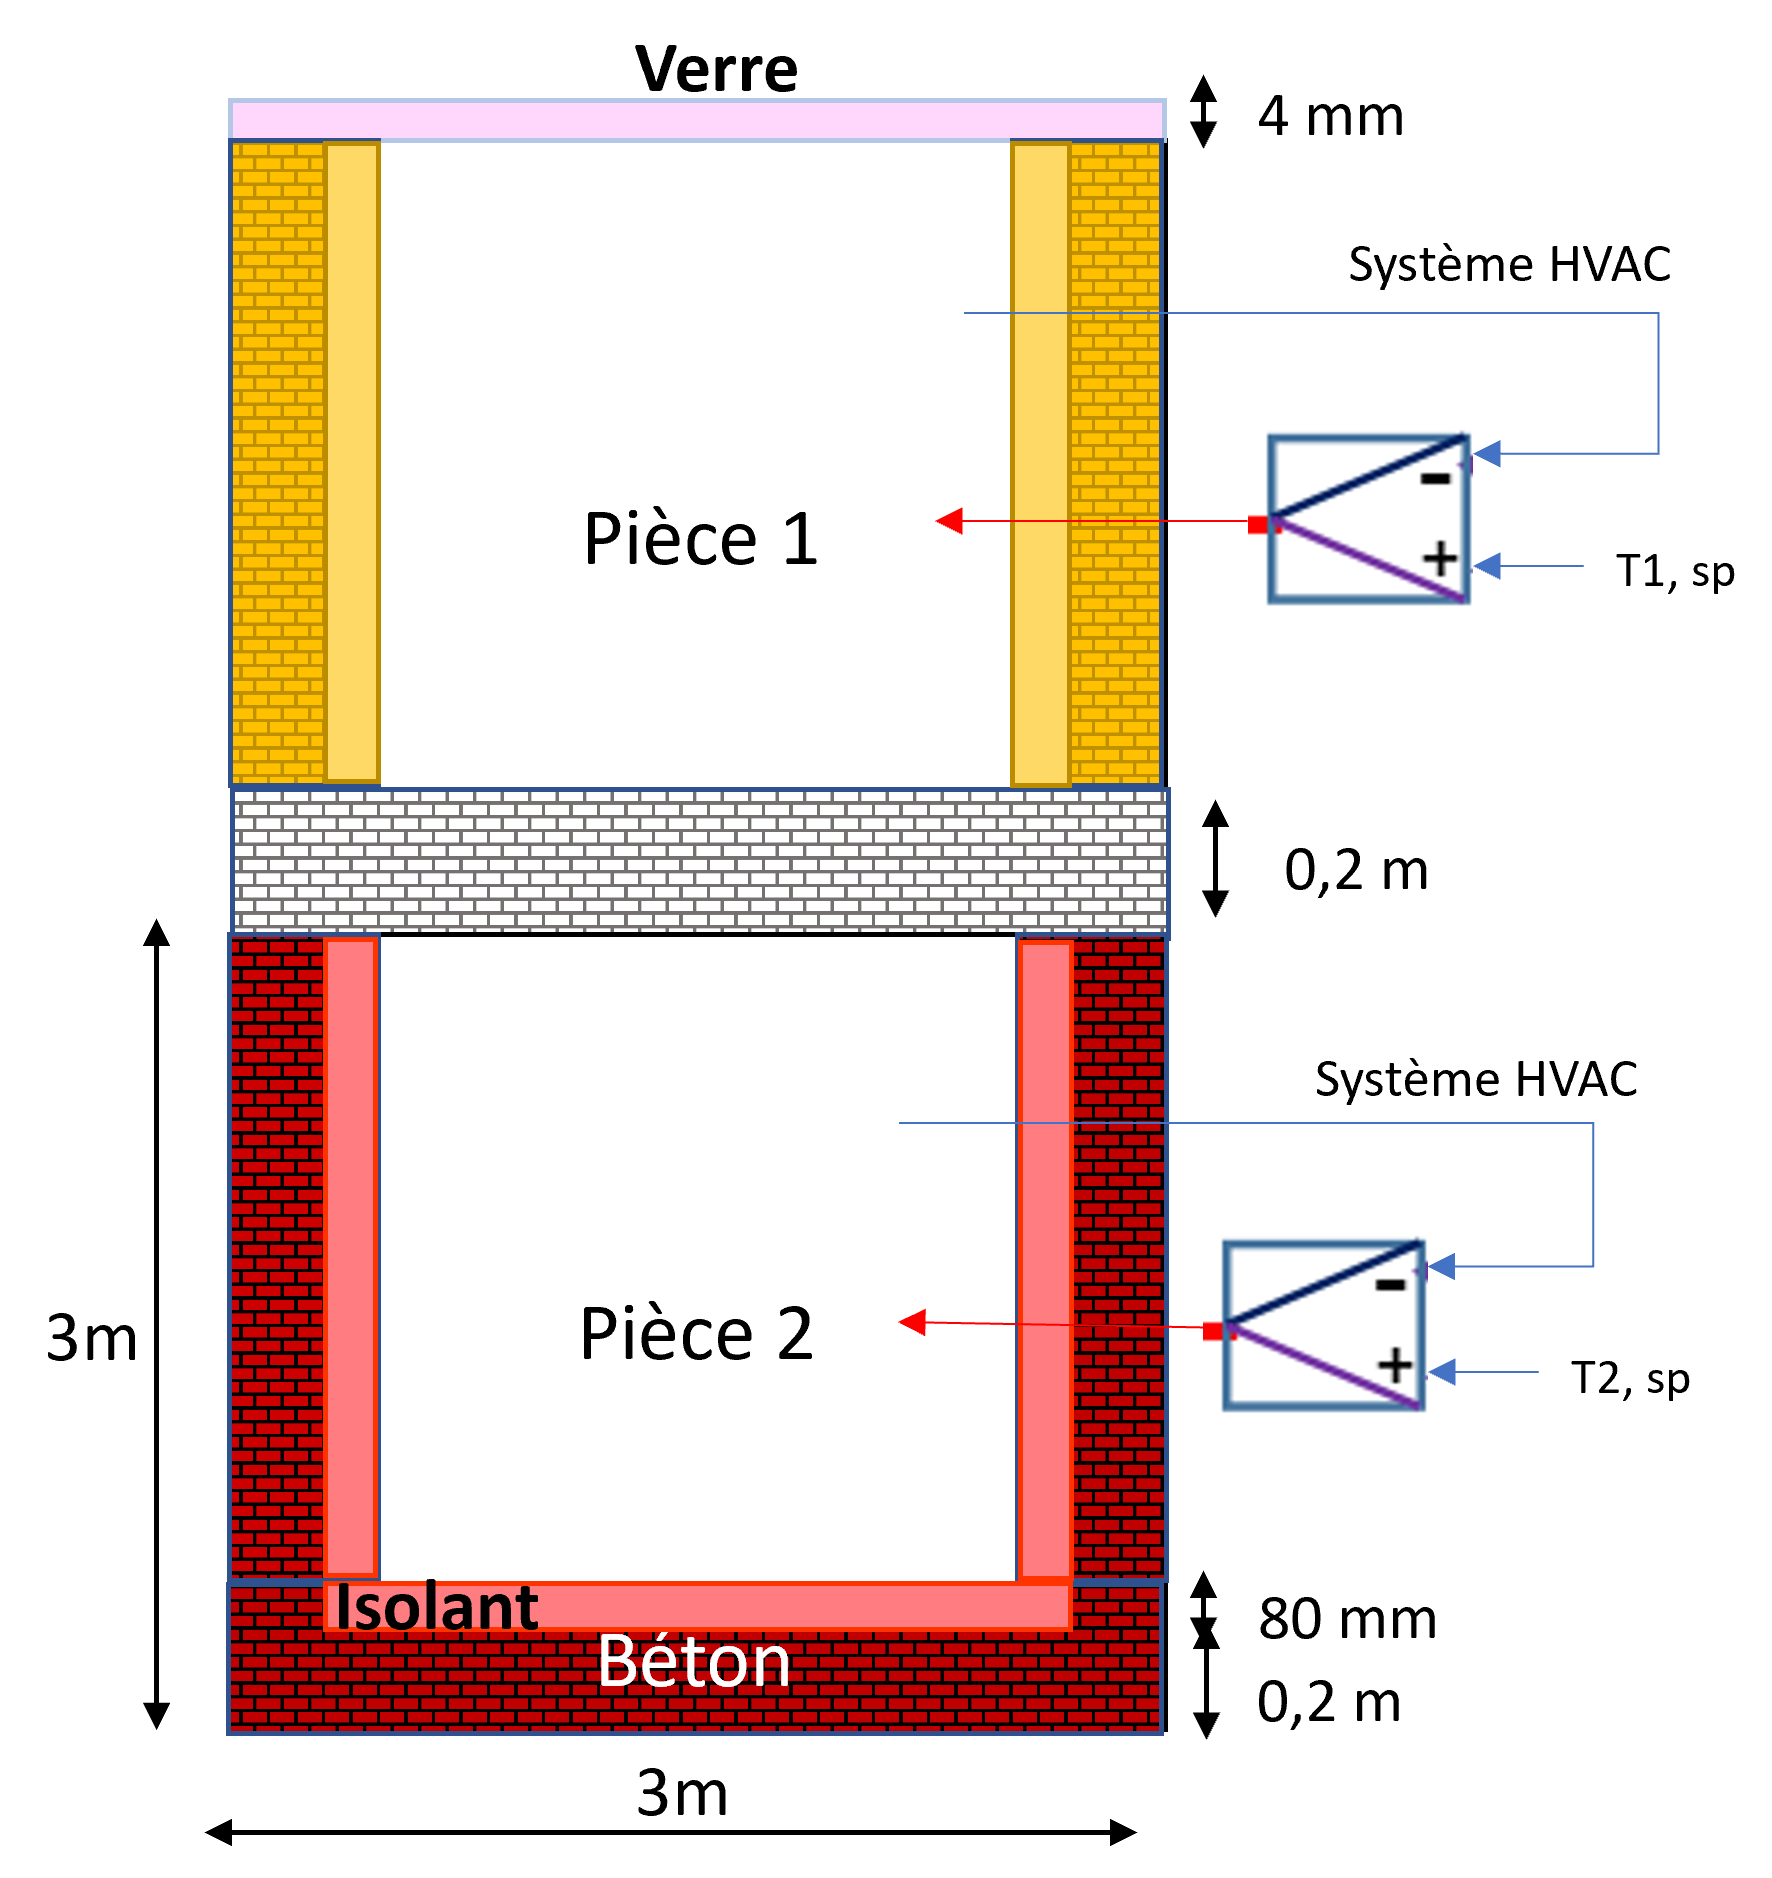
</div>

> Figure 1. Schéma de la situation étudiée, deux salles controllées de manière proportionelle par un systeme HVAC.

In [2]:
l = 3               # m length of the cubic room
Sg = l**2           # m² surface of the glass wall
S_room_1 = 4 * Sg   # m² surface of concrete & insulation of the 4 walls (roof, ground, and 2 walls)
S_room_2 = 5 * Sg   # m² surface of concrete & insulation of the 5 walls (roof, ground, and 3 walls)
S_wall = Sg         # m² surface of concrete & insulation of the walls

### Thermodynamique du problème
 - determination des caractéristiques thermiques de l'air
 - determination des caractéristiques thermiques des murs

In [3]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


In [4]:
wall = {'Conductivity': [1.4, 0.027, 1.4, 1.4, 0.027, 1.4],  # W/(m·K)
        'Density': [2300, 55, 2500, 2300, 55, 2300],        # kg/m³
        'Specific heat': [880, 1210, 750, 880, 1210, 880],  # J/(kg·K)
        'Width': [0.2, 0.08, 0.004, 0.2, 0.08, 0.2],
        'Surface': [S_room_1, S_room_1, Sg, S_room_2, S_room_2, S_wall],  # m²
        'Slices': [1, 1, 1, 1, 1, 1]}                # number of  slices
wall = pd.DataFrame(wall, index=['Concrete_1', 'Insulation_1', 'Glass', 'Concrete_2', 'Insulation_2', 'Concrete_wall'])
wall

,Conductivity,Density,Specific heat,Width,Surface,Slices
Concrete_1,1.400,2300,880,0.200,36,1
Insulation_1,0.027,55,1210,0.080,36,1
Glass,1.400,2500,750,0.004,9,1
Concrete_2,1.400,2300,880,0.200,45,1
Insulation_2,0.027,55,1210,0.080,45,1
Concrete_wall,1.400,2300,880,0.200,9,1


Les propriétés radiatives des surfaces sont les suivantes : 
 - l'emmisivité en ondes longues du béton (entre normal et rugueux) et du verre pyrex ;
 - l'absorption du rayonnement solaire en ondes courtes des surfaces blanches lisses ;
 - la transmittance en ondes courtes du verre de fenêtre (épaisseur de 4 mm) ;
 - l'absorptivité et la transmittance en ondes courtes d'une vitre bleue réfléchissante.

In [5]:
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

 - Définition de la constante de Boltzmann

In [6]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

σ = 5.67e-08 W/(m²⋅K⁴)


- Définition des facteurs de formes

In [7]:
Fwg = 1 / 5     # view factor wall - glass
Fwg

0.2

- Définition des valeurs des coefficients de convection thermique pour l'intérieur et l'extérieur

In [8]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
h

,in,out
h,8.0,25


### Circuit Thermique
Le transfert de chaleur se fait :
- à travers les murs (béton et isolation),
- à travers la fenêtre en verre,
- par la ventilation, (dans notre cas elle est nulle)
- à partir de sources auxiliaires intérieures,
- par le système de chauffage, de ventilation et de climatisation.

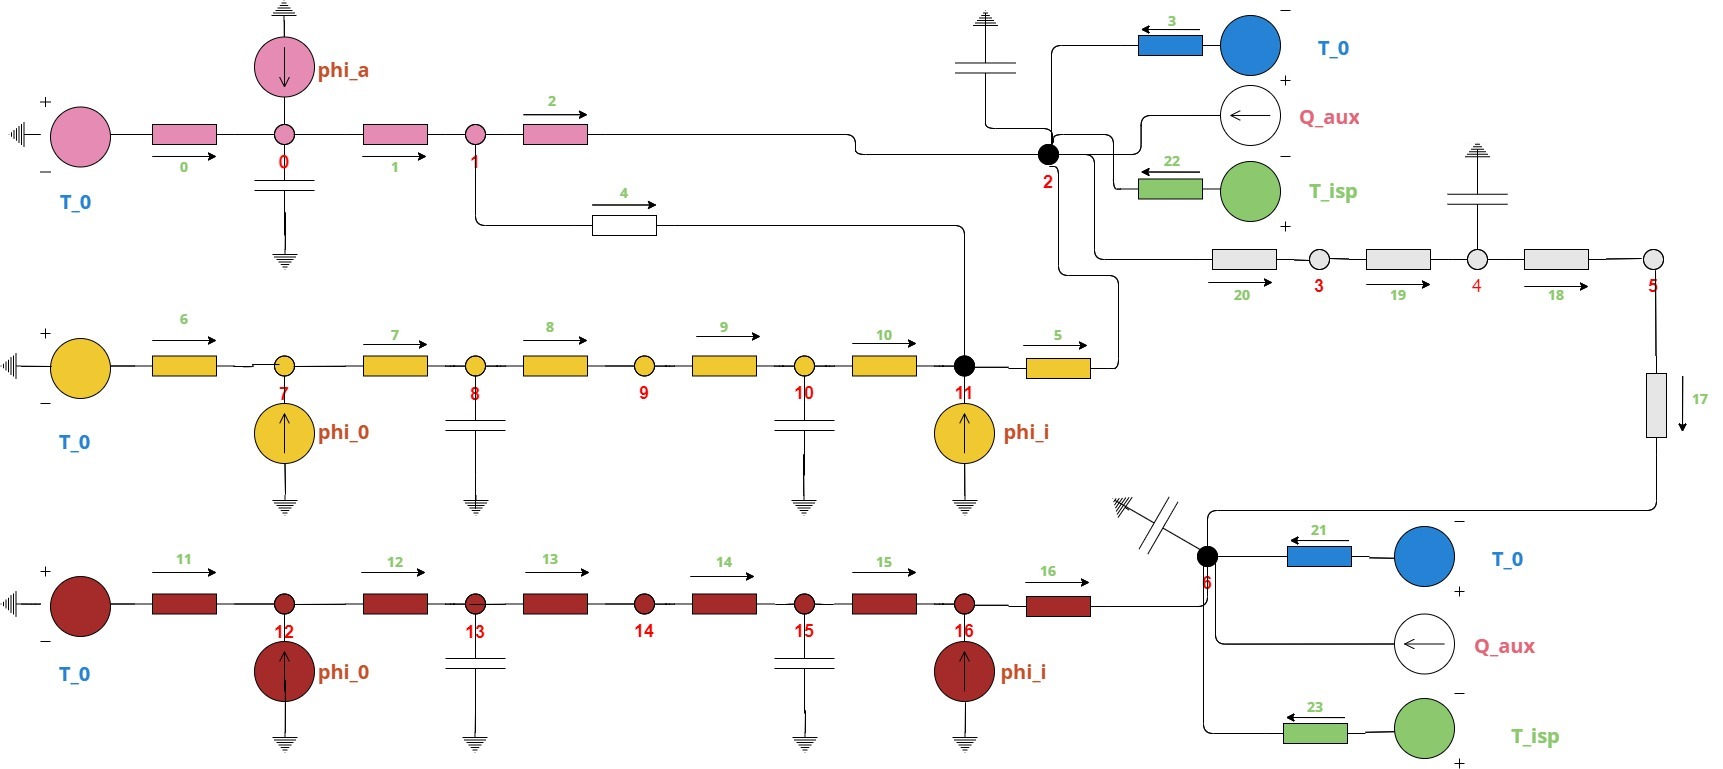

> Figure 2. Schéma électrique de notre cas d'étude.

Chaque couleur correspond a une partie de notre batiment :
- en rose : la vitre
- en jaune : le plafond, le sol et les murs du coté (mur gauche et droite) de la salle 1
- en rouge : le plafond, le sol et les 3 murs de la salle 2
- en gris : le mur intermediaire qui separe les deux pièces
- en bleu : le systeme de ventilation
- en vert : le systeme de controle HVAC

#### Définition des conductances
- pour un transfert par conduction

In [9]:
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

,Conductance
Concrete_1,252.0000
Insulation_1,12.1500
Glass,3150.0000
Concrete_2,315.0000
Insulation_2,15.1875
Concrete_wall,63.0000


- pour un transfert par convection

In [10]:
# Convection
Gw_1 = h * wall['Surface'][0]     # room 1
Gw_2 = h * wall['Surface'][3]     # room 2
Gw = h * wall['Surface'][4]     # room 2
Gg = h * wall['Surface'][2]     # glass

- pour un transfert par radiation

In [11]:
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation_1']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Insulation_1']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

# Soit la conductance équivalente :

GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

- pour un transfert par advection

In [12]:
Va = l**3                   # m³ volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s air infiltration

# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot

 - Mise en place d'un controlleur proportionnel pour modéliser le système de ventilation HVAC qui permet de controller la temperature intérieure du batiment. On a alors un flux de chaleur qui se rajoute tel que :

In [13]:
# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
Kp = 1e-3           # no controller Kp -> 0
Kp = 0

In [14]:
# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))

#### Définition des capacités thermiques du batiment
- pour les murs

In [15]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']

- pour l'air

In [16]:
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns={'Capacity'})

,Capacity
Concrete_1,14572800.0
Insulation_1,191664.0
Glass,67500.0
Concrete_2,18216000.0
Insulation_2,239580.0
Concrete_wall,3643200.0
Air,32400.0


### Mise en place du système d'équations algébriques différentielles
L'analyse d'un circuit thermique, ou problème direct, consiste à trouver les températures dans les nœuds, $\theta$, et les flux de chaleur sur les branches, $q$, c'est-à-dire à résoudre pour $\theta$ et $q$ le système d'[équations différentielles-algébriques (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) (Figures 3 et 4) :

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

où :
- $\theta$ est le vecteur de température de taille $n_\theta$ égale au nombre de nœuds ;
- $q$ - vecteur de flux de chaleur de taille $n_q$ égale au nombre de branches ;
- $A$ - matrice d'incidence (https://en.m.wikipedia.org/wiki/Incidence_matrix) de taille $n_q$ lignes et $n_{\theta}$ colonnes, où $n_q$ est le nombre de branches de flux et $n_{\theta}$ le nombre de nœuds de température. Il montre comment les nœuds de température sont connectés par des branches orientées de flux de chaleur :
    - si le flux *m* entre dans le noeud *n*, alors l'élément (*m, n*) de la matrice $A$ est 1, c'est-à-dire $A_{m,n} = 1$ ;
    - si le flux *m* sort du noeud *n*, alors l'élément (*m, n*) de la matrice $A$ est -1, c'est-à-dire $A_{m,n} = -1$, ; 
    - si le flux *m* n'est pas connecté au nœud *n*, alors l'élément (*m, n*) de la matrice $A$ est 0, c'est-à-dire $A_{m,n} = 0$.

- $G$ - matrice diagonale de conductance de taille $n_q \ fois n_q$, où $n_q$ est le nombre de branches d'écoulement : matrice diagonale contenant les conductances. Chaque branche $k$ doit contenir une conductance $0 < G_{k,k} < \infty $. 

- $C$ - matrice diagonale de capacité de taille $n_θ \times n_θ$, où $n_θ$ est le nombre de nœuds de température : matrice diagonale contenant les capacités. S'il n'y a pas de capacité dans le nœud *n*, alors $C_{n, n} = 0$.

- $b$ - vecteur source de température de taille $n_q$ : s'il n'y a pas de source de température sur la branche *m*, alors $b_m = 0$.

- $f$ - vecteur source de flux de chaleur de taille $n_θ$ : s'il n'y a pas de source de flux de chaleur dans le noeud *n*, alors $f_n = 0$.

La résolution est d'abord effectuée pour les températures, $\theta$, en résolvant l'équation :

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

qui, en général, est un système d'équations algébriques différentielles (DAE). Ensuite, les débits de chaleur sont trouvés à partir de l'équation :

$$q = G (-A \theta + b)$$

#### Définition des différentes matrices 
- mise en place de la matrice incidente

In [17]:
A = np.zeros([24, 17])       # n° of branches X n° of nodes
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
   
A[4, 1], A[4, 11] = -1, 1

A[5, 11], A[5, 2] = -1, 1

A[6, 7] = 1
A[7, 7], A[7, 8] = -1, 1
A[8, 8], A[8, 9] = -1, 1
A[9, 9], A[9, 10] = -1, 1
A[10, 10], A[10, 11] = -1, 1

A[11, 12] = 1
A[12, 12], A[12, 13] = -1, 1
A[13, 13], A[13, 14] = -1, 1
A[14, 14], A[14, 15] = -1, 1
A[15, 15], A[15, 16] = -1, 1

A[16, 16], A[16, 6] = -1, 1

A[17, 5], A[17, 6] = -1, 1
A[18, 4], A[18, 5] = -1, 1
A[19, 3], A[19, 4] = -1, 1
A[20, 2], A[20, 4] = -1, 1

A[3, 2], A[22, 2] = 1, 1
A[21, 6], A[23, 6] = 1, 1

 -  mise en place de la matrice de conductance

In [18]:
G = np.diag(np.hstack(
    [Ggs, 2 * G_cd['Glass'], Gg['in'], Gv, GLW,
     Gw_1['in'], Gw_1['out'], 2 * G_cd['Concrete_1'], 2 * G_cd['Concrete_1'],
     2 * G_cd['Insulation_1'], 2 * G_cd['Insulation_1'],
     Gw_2['out'], 2 * G_cd['Concrete_2'], 2 * G_cd['Concrete_2'],
     2 * G_cd['Insulation_2'], 2 * G_cd['Insulation_2'], Gw_2['in'],
     Gw['in'], 2 * G_cd['Concrete_wall'], 2 * G_cd['Concrete_wall'], Gw['in'],
     Gv, Kp, Kp]))

- mise en place de la matrice de capacité

In [19]:
neglect_air_glass = False

if neglect_air_glass:
    C = np.diag([0, 0, 0, 0, C['Concrete_wall'], 0,
                 0, 0, C['Concrete_1'], 0, C['Insulation_1'],
                 0, 0, C['Concrete_2'], 0, C['Insulation_2'], 0])
else:
    C = np.diag([C['Glass'], 0, C['Air'], 0, C['Concrete_wall'], 0,
                 C['Air'], 0, C['Concrete_1'], 0, C['Insulation_1'],
                 0, 0, C['Concrete_2'], 0, C['Insulation_2'], 0])

- mise en place du vecteur des températures sources

In [20]:
b = np.zeros(24)        # branches
b[[0, 3, 6, 11, 21, 22, 23]] = 1   # branches with temperature sources
print(f'b = ', b)

b =  [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]


- mise en place du vecteur source des flux de chaleur

In [21]:
f = np.zeros(17)         # nodes
f[[0, 2, 6, 7, 11, 12, 16]] = 1     # nodes with heat-flow sources
print(f'f = ', f)

f =  [1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1.]


- mise en place du vecteur de sortie

Le vecteur des sorties est $y$, de taille $n_{\theta}$, le nombre de nœuds. Les valeurs non nulles de $y$ indiquent les nœuds qui sont les sorties du modèle.

In [22]:
y = np.zeros(17)         # nodes
y[[2, 6]] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Mise en place de la representation d'espace-état


Le [système d'équations différentielles-algébriques (DAE)] (https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

est transformé en [représentation espace-état](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)) :

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_C + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

où :
- $\theta_s$ est le vecteur des variables d'état qui sont les températures des nœuds contenant des capacités ; les éléments sont dans le même ordre que dans le vecteur des températures, $\theta$ ; sa dimension, $\dim \theta_s$, est égale au nombre de capacités du réseau thermique ; pour le circuit présenté dans la Figure 3, $\theta_s = [\theta_1, \theta_3, \theta_6, \theta_7]^T$ ;

- $u = \begin{bmatrix} b_T \\\ f_Q\end{bmatrix}$ 
vecteur d'entrées de dimension $\dim u$ égale au nombre de sources (de température et de flux de chaleur) du réseau thermique, où :

    - vecteur $b_T$ d'éléments non nuls du vecteur $b$ de sources de température ; pour le circuit présenté à la figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ correspond aux branches 0, 8, 10 et 11 ; 
    - vecteur $f_Q$ des éléments non nuls du vecteur $f$ des sources de flux ; pour le circuit présenté à la figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ correspond aux nœuds 0, 4, 6 et 7 ;
    
- $y$ - vecteur de sorties est un sous-ensemble du vecteur $\theta$ représentant les nœuds de température qui nous intéressent ; pour le circuit présenté à la figure 3, $y = \theta_6$, la température intérieure.

- $A_s$ - matrice d'état, de dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;

- $B_s$ - matrice d'entrée, de dimension $\dim B_s = \dim {\theta_s} \times \dim u$;

- $C_s$ - matrice de sortie, de dimension $\dim C_s = \dim y \times \dim {\theta_s}$;

- $D_s$ - matrice d'entrée (ou de sortie), de dimension $\dim D_s = \dim y \times \dim u$.


In [23]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-4.74429882e-03  1.48881762e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  3.70903977e-05  0.00000000e+00  0.00000000e+00]
 [ 3.10170337e-03 -1.51110445e-02  1.11111111e-02  0.00000000e+00
   0.00000000e+00  6.20452196e-04  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.88142292e-05 -1.24432733e-04  2.56185039e-05
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.88065844e-03 -4.02298953e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  8.64553314e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.37606504e-05  1.59079125e-06  0.00000000e+00  0.00000000e+00]
 [ 1.30624522e-05  1.04884857e-04  0.00000000e+00  0.00000000e+00
   1.20952723e-04 -2.38900032e-04  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.37606504e-05  1.59079125e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.16919306e

### Mise en place de l'état stationnaire
[Steady-state](https://en.m.wikipedia.org/wiki/Steady_state) signifie que dans le système DAE, le terme $C \dot \theta = 0$.

Dans [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), le modèle peut être vérifié s'il est incorrect. Considérons que
- le régulateur n'est pas actif, $K_p \rightarrow 0$,
- la température extérieure est $T_o = 10 \, \mathrm{^\circ C}$,
- le point de consigne de la température intérieure est $T_{i,sp} = 20 \, \mathrm{^\circ C}$,
- toutes les sources de débit sont nulles.

In [24]:
b = np.zeros(24)        # temperature sources
b[[0, 3, 6, 11, 21]] = 10      # outdoor temperature
b[[22, 23]] = 20            # indoor set-point temperature

f = np.zeros(17)         # flow-rate sources

#### Système d'équations algébriques différentielles (DAE)
La valeur de la température en état stationnaire (https://en.m.wikipedia.org/wiki/Steady_state) est obtenue à partir du système DAE en considérant que $C \dot{\theta} = 0$ :

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

Pour les conditions mentionnées ci-dessus, en régime permanent, toutes les températures $\theta_0 ... \theta_7$, y compris la température de l'air intérieur $\theta_6$, sont égales à $T_o = 10 \, \mathrm{^\circ C}$.

In [25]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.] °C


#### Représentation de l'espace d'état
Le vecteur d'entrée $u$ est obtenu en empilant les vecteurs $b_T$ et $f_Q$ :

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

où :
- $b_T$ est un vecteur des éléments non nuls du vecteur $b$ des sources de température. Pour le circuit présenté à la figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ correspondant aux branches 0, 8, 10 et 11, où :
    - $T_o$ - température extérieure, °C ;
    - $T_{i,sp}$ - température de consigne pour l'air intérieur, °C.
- $f_Q$ est le vecteur des éléments non nuls du vecteur $f$ des sources de débit. 

In [26]:
bT = np.array([10, 10, 10, 10, 10, 20, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [10 10 10 10 10 20 20  0  0  0  0  0  0  0]


La valeur d'équilibre de la sortie de la représentation de l'espace d'état est obtenue lorsque $\dot \theta_{C} = 0$ :

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [27]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [10. 10.] °C


L'erreur entre les valeurs de l'état stable obtenues à partir du système DAE, $\theta_6$, et la sortie de la représentation de l'espace d'état, $y_{ss}$, 

$$\varepsilon = \left | \theta_6 - y_{ss} \right |$$

est pratiquement nulle ; la légère différence est due à des [erreurs numériques] (https://en.m.wikipedia.org/wiki/Numerical_error).

In [28]:
print(f'Max error between DAE and state-space: \
{max(abs(θ[6] - yss)):.2e} °C')

Max error between DAE and state-space: 5.51e-14 °C


### Simulation Dynamique
#### Pas de temps

La condition de [stabilité numérique](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) de la méthode [d'intégration explicite d'Euler](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) est la suivante

$$\left | \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

c'est-à-dire que dans le plan complexe, $\lambda_i \Delta t$ est à l'intérieur d'un cercle de rayon 1 centré sur {-1, 0j}, où :
- $\lambda_i$ sont les valeurs propres de la matrice $A_s$,
- $\Delta t$ - pas de temps.

Pour des valeurs propres réelles positives $\left \{ \lambda \in \Re |\lambda >0 \right \}$, ce qui est le cas des réseaux thermiques, la condition ci-dessus [devient](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1 < 1, \forall \lambda_i, $$

ou

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = 2 \min -\frac{1}{\lambda_i} = 2 \min T_i$$

où $T_i$ sont les [constantes de temps] (https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $

In [29]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [   64.057333     231.04928492   245.88408535  4224.24988973
  4655.57317506 39351.03238579 47036.01708054 43843.42642381] s 

2 x Time constants: 
 [  128.11466599   462.09856985   491.76817069  8448.49977946
  9311.14635011 78702.06477157 94072.03416108 87686.85284763] s 

Maximum time step: 128.11 s = 2.14 min


Choisissons un pas de temps plus petit que $\Delta t_{max} = \min -2 / \lambda_i $.

In [30]:
dt = 2 * 60     # seconds
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 120 s = 2 min


#### Temps de convergence du modèle

In [31]:
t_resp = 4 * max(-1 / λ)
print('Time constants: \n', -1 / λ, 's \n')
print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
= {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

Time constants: 
 [   64.057333     231.04928492   245.88408535  4224.24988973
  4655.57317506 39351.03238579 47036.01708054 43843.42642381] s 

Settling time: 188144 s = 3135.7 min = 52.26 h = 2.18 days


### Premières Simulations
#### Reponse face à une entrée échelon (step response)
- duree de la simulation

In [32]:
duration = 2 * 3600 * 24 * 2            # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 345600 s
Number of time steps = 2880


- vecteur d'entrée

Dans la simulation dynamique, les entrées sont des [séries temporelles] (https://en.m.wikipedia.org/wiki/Time_series), par exemple, la température extérieure aura $n$ valeurs $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ à temps discret $t = [t_0, t_1, ... , t_{n-1}]^T$.

In [33]:
u = np.zeros([14, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0:5, :] = 10 * np.ones([5, n])    # To = 10 for n time steps
u[5, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps

- integration en temps en utilisant un modèle de type Euler 

On a respectivement l'utilisation d'un modèle explicite puis d'un modèle implicite.

In [34]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

On obtient alors les résultats suivants, qui révèlent une intégration presque identique du modèle :

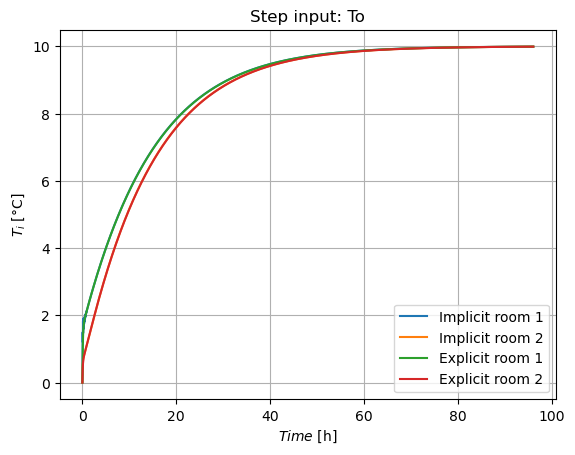

In [35]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u


# The results of explicit and implicit Euler integration are practically identical.

# In[39]:


fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T[:,0], t / 3600, y_exp.T[:,1])
ax.plot(t / 3600, y_imp.T[:,0], t / 3600, y_imp.T[:,1])
ax.set(xlabel='$Time$ [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To')
#ax.legend(['Explicit', 'Implicit'])
ax.legend(['Implicit room 1', 'Implicit room 2', 'Explicit room 1', 'Explicit room 2'])
ax.grid()
plt.show()

> Figure 3. Réponse progressive à la température extérieure en utilisant la méthode d'Euler.

La valeur de la température intérieure obtenue après le temps de stabilisation (https://en.m.wikipedia.org/wiki/Settling_time) est presque égale à la valeur obtenue en régime permanent.

In [40]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[6]):.4f} °C')
print(f'- state-space model: {float(np.mean(yss)):.4f} °C')
#print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 10.0000 °C
- state-space model: 10.0000 °C


### Simulation avec la prise en compte des données météo

La simulation sera effectuée de `start_date` à `end_date` dans le format `MM-DD HH:MM:SS` (mois, jour, heure:minute:seconde).

In [41]:
start_date = '07-03 12:00:00'
end_date = '08-05 18:00:00'

2000-07-03 12:00:00 	start date
2000-08-05 18:00:00 	end date


Les données météorologiques concernent une année. Le choix de `2000` pour l'année est arbitraire ; il est utilisé pour respecter le format `AAA-MM-JJ HH:MM:SS`.

In [ ]:
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

In [42]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

A partir des données météorologiques, nous sélectionnons
- la température horaire de l'air extérieur, °C ;
- l'irradiation solaire directe normale (https://en.m.wikipedia.org/wiki/Direct_insolation) (ou rayonnement), W/m² ;
- l'irradiation solaire horizontale diffuse horaire (ou [irradiation diffuse du ciel](https://en.wikipedia.org/wiki/Diffuse_sky_radiation)), W/m²,

de la date de début à la date de fin.

In [43]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(
    weather.index >= start_date) & (
    weather.index < end_date)]

# pd.DataFrame(weather)

##### Rayonnement solaire sur les murs
Pour l'orientation de la surface donnée par `pente`, `azimut` et `latitude`, et l'albédo` de la surface devant le mur, en utilisant les données météorologiques, nous pouvons calculer le :
- l'irradiation directe, W/m²,
- l'irradiation diffuse, W/m²,
- l'irradiation réfléchie, W/m²,

pour l'irradiance solaire horaire (https://en.m.wikipedia.org/wiki/Solar_irradiance) sur une surface inclinée.

In [44]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
# pd.DataFrame(rad_surf)

L'irradiation solaire totale (https://en.m.wikipedia.org/wiki/Solar_irradiance) $E_{tot}$, en W/m², est la somme des composantes directes, diffuses et réfléchies.  

In [46]:
rad_surf['Etot'] = rad_surf.sum(axis=1)

##### Rééchantillonner les données météorologiques
Les données météorologiques sont au pas de temps de 1h. Elles doivent être rééchantillonnées au pas de temps $\Delta t$ utilisé pour l'intégration numérique.


In [47]:
data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
# pd.DataFrame(data)

##### Autres entrées
Considérons le point de consigne de la température intérieure $T_{i,sp} = 20 \, \mathrm{^\circ C}$ et le flux de chaleur auxiliaire $\dot{Q}_a = 0 \, \mathrm{W}$ constant pour toute la durée de la simulation.


In [48]:
T_int = 20 # °C
q_aux = 0 # W


data['Ti'] = T_int * np.ones(data.shape[0])
data['Qa'] = q_aux * np.ones(data.shape[0])

#### Définition des vecteurs d'entrée dans le temps

In [38]:
To = data['To']
Ti = data['Ti']

Φo_1 = α_wSW * wall['Surface']['Concrete_1'] * data['Etot']
Φi_1 = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
Φo_2 = α_wSW * wall['Surface']['Concrete_2'] * data['Etot']
Φi_2 = 0 * τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']

Qa = data['Qa']
Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

u = pd.concat([To, To, To, To, To, Ti, Ti, Φa, Qa, Qa, Φo_1, Φi_1, Φo_2, Φi_2], axis=1)
u.columns.values[[7, 10, 11, 12, 13]] = ['Φa', 'Φo_1', 'Φi_1', 'Φo_2', 'Φi_2']
# pd.DataFrame(u)

- Condition initiale

In [49]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

#### Intégration dans le temps
Intégration temporelle [Explicit Euler] (https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method),

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

où $k = 0, ... , n - 1$,

In [50]:
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

donne la variation temporelle de la variable d'état $\theta$, à partir de laquelle nous obtenons la variation de la sortie (c'est-à-dire la température intérieure) :

$$y = C_s \theta_s + D_s u$$

et la variation du flux de chaleur du système HVAC :

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

où $K_p$ est le gain du régulateur P et $T_{i,sp}$ est le point de consigne CVC pour la température intérieure.

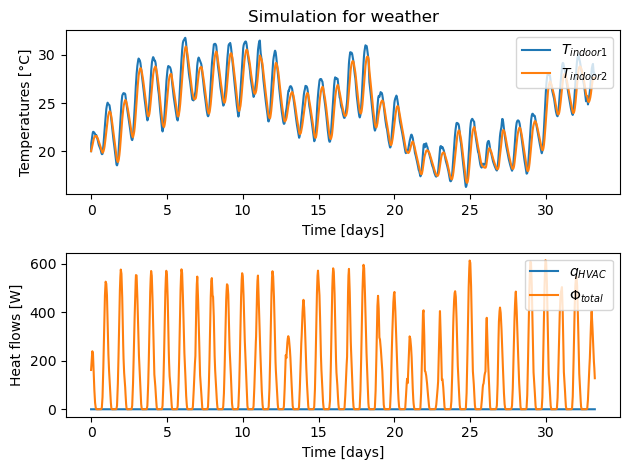

In [51]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])


# In[53]:


t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor1}$')
axs[0].plot(t / 3600 / 24, y_exp[1, :], label='$T_{indoor2}$')
#axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [days]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 4. Simulation en marche libre avec les données météorologiques en utilisant la méthode d'intégration explicite d'Euler. a) Températures intérieure et extérieure. b) Débits de chaleur solaire et CVC.